In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
data_df = pd.read_csv('./data_train_all_0824.csv')
data_array = np.array(data_df)
x_train_all = data_array[:, :3]
y_train_all = data_array[:, 3:]
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.2, shuffle=False, random_state=1)
x_test = np.array(pd.read_csv('./data_eval_v_0.7.csv'))[:, :3]
y_test = np.array(pd.read_csv('./data_eval_v_0.7.csv'))[:, 3:]

scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)

x_train_copy = x_train.copy()
x_valid_copy = x_valid.copy()
x_test_copy = x_test.copy()

y_train_copy = y_train.copy()
y_valid_copy = y_valid.copy()
y_test_copy = y_test.copy()

x_train = scaler_x.transform(x_train)
x_valid = scaler_x.transform(x_valid)
x_test = scaler_x.transform(x_test)
x_train_all = scaler_x.transform(x_train_all)

# x_train = scaler_x.transform(x_train).reshape(-1, 1, 3)
# x_valid = scaler_x.transform(x_valid).reshape(-1, 1, 3)
# x_test = scaler_x.transform(x_test).reshape(-1, 1, 3)
# x_train_all = scaler_x.transform(x_train_all).reshape(-1, 1, 3)

y_train = scaler_y.transform(y_train)
y_valid = scaler_y.transform(y_valid)
y_test = scaler_y.transform(y_test)

print(x_train.shape)
print(scaler_y.inverse_transform(y_train))


(1724, 3)
[[ 0.     30.    ]
 [ 0.     30.7864]
 [ 0.     31.8199]
 ...
 [ 0.5282 57.3585]
 [ 0.5531 57.9181]
 [ 0.5779 58.475 ]]


In [3]:
# model = MLPRegressor(solver='adam', alpha=1e-3, hidden_layer_sizes=(32, 16), activation='logistic', learning_rate='adaptive', power_t=0.5, 
#     learning_rate_init=0.005, max_iter=2000, tol=1e-4, early_stopping=False, validation_fraction=0.1, random_state=1)

# model.fit(x_train, y_train)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

def mlp_regressor():
    model = Sequential()
    # model.add(Input(shape=(1, 3)))
    model.add(Input(shape=(3,)))
    # model.add(LSTM(32, return_sequences=False))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(16, activation='sigmoid'))
    # model.add(Dense(8, activation='sigmoid'))
    # model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(2, activation=None))
    model.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['mse'])   
    return model

# def mlp_regressor():
#     inputs = Input(shape=(3,))
#     inputs = inputs[:, :2]
#     x_1 = Dense(8, activation='sigmoid')(inputs)
#     x_2 = Dense(16, activation='sigmoid')(inputs)
#     x = Dense(8, activation='sigmoid')(x_2) + x_1
#     outputs = Dense(2, activation=None)(x)
#     model = Model(inputs=[inputs], outputs=outputs)
#     model.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['mse'])   
#     return model

callbacks = [EarlyStopping(monitor='val_mse', min_delta=1e-5, patience=100),
             ModelCheckpoint("./checkpoints/mlp.hdf5", monitor='val_mse',
                             mode='min', verbose=0, save_best_only=True)]

model = mlp_regressor()

In [5]:
history = model.fit(x_train, np.array(y_train), batch_size=16, epochs=1000, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.1668 - mse: 0.1668 - val_loss: 0.1064 - val_mse: 0.1064
Epoch 2/1000
108/108 [==============================] - 0s 543us/step - loss: 0.0865 - mse: 0.0865 - val_loss: 0.0985 - val_mse: 0.0985
Epoch 3/1000
108/108 [==============================] - 0s 481us/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 4/1000
108/108 [==============================] - 0s 501us/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 5/1000
108/108 [==============================] - 0s 395us/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 6/1000
108/108 [==============================] - 0s 523us/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 7/1000
108/108 [==============================] - 0s 392us/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 8/1000
108/108 [============================

In [6]:
model.load_weights('./checkpoints/mlp.hdf5')

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.eval import get_ia, get_mae, get_mse, get_rmse, get_r, get_u95

# y_pred = linear_reg.predict(poly_reg.fit_transform(x_test))

pred_result = model.predict(x_valid)
pred_result = scaler_y.inverse_transform(pred_result)

y_pred = pred_result[:, 0]
y_true = y_valid_copy[:, 0]
y_pred[y_pred > 1.0] = 1.0
y_pred[y_pred < 0.0] = 0.0

# print(y_pred, y_true)
print(np.sqrt(mean_squared_error(y_pred, y_true)))

y_pred = pred_result[:, 1]
y_true = y_valid_copy[:, 1]

for i in range(x_valid.shape[0]):
    if y_pred[i] > x_valid_copy[i, 1]:
        y_pred[i] = x_valid_copy[i, 1]

# print(y_pred, y_true)
print(np.sqrt(mean_squared_error(y_pred, y_true)))

0.017956887113815267
1.6895058562206642


In [8]:
import pandas as pd
import numpy as np
from utils.eval import get_ia, get_mae, get_mse, get_rmse, get_r, get_u95, get_mre

def model_predict_from_csv(data_eval):

    # x_test = np.array(pd.read_csv(data_eval))[:, :3]
    # y_test = np.array(pd.read_csv(data_eval))[:, 3:]

    # x_test_copy = x_test.copy()
    # x_test = scaler.transform(x_test)
    
    # print(data_copy)

    frac_true = y_test_copy[:, 0]
    temp_pcm_true = y_test_copy[:, 1]

    pred_result = model.predict(x_test)
    pred_result = scaler_y.inverse_transform(pred_result)
    
    frac_pred = pred_result[:, 0]
    frac_pred[frac_pred > 1.0] = 1.0  # 将液相率大于1的值重设为1
    frac_pred[frac_pred < 0.0] = 0.0
    temp_pcm_pred = pred_result[:, 1]
    for i in range(x_test.shape[0]):
        temp_pcm_pred[i] = np.min((temp_pcm_pred[i], x_test_copy[i, 1]))

    print ("fraction mae:", mean_absolute_error(frac_true, frac_pred))
    print ("fraction mse:", mean_squared_error(frac_true, frac_pred))
    print ("fraction rmse:", np.sqrt(mean_squared_error(frac_true, frac_pred)))
    print('---------------------------------------------------')
    print ("temperature mae:", mean_absolute_error(temp_pcm_true, temp_pcm_pred))
    print ("temperature mse:", mean_squared_error(temp_pcm_true, temp_pcm_pred))
    print ("temperature rmse:", np.sqrt(mean_squared_error(temp_pcm_true, temp_pcm_pred)))

    result_df = pd.DataFrame({"velo_in": x_test_copy[:, 0], "temp_in": x_test_copy[:, 1], "time": x_test_copy[:, 2], "frac_true": frac_true, "frac_pred": frac_pred, "temp_pcm_true": temp_pcm_true, "temp_pcm_pred":temp_pcm_pred})
    result_df.to_csv(f"./results/predict_from_csv_result_mlp.csv", index=False)

    return None

data_eval = './data_eval_v_0.7.csv'
model_predict_from_csv(data_eval)



fraction mae: 0.011700655060106162
fraction mse: 0.00021548268690297772
fraction rmse: 0.014679328557634293
---------------------------------------------------
temperature mae: 0.33723566470516436
temperature mse: 0.16480848815349694
temperature rmse: 0.4059661170017726


<Figure size 432x288 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

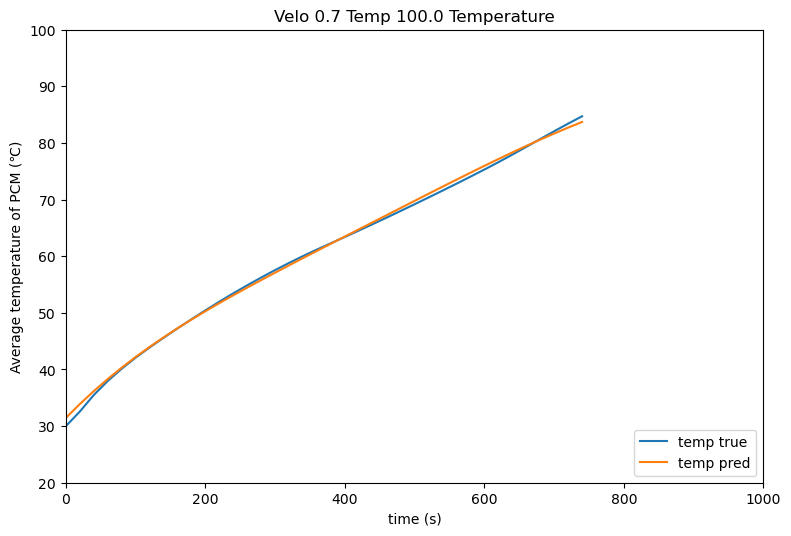

In [9]:
import pandas as pd
import numpy as np
from utils.eval import get_ia, get_mae, get_mse, get_rmse, get_r, get_u95, get_mre
import matplotlib.pyplot as plt

def plot_result(result_file):
    result_df = pd.read_csv(result_file)
    eval_df = pd.DataFrame(columns=['velo_in', 'temp_in', 'len_data', 'r_frac', 'mae_frac', 'rmse_frac', 'ia_frac', 'u95_frac', 'mre_frac', 'r_temp', 'mae_temp', 'rmse_temp', 'ia_temp', 'u95_temp', 'mre_temp'])
    
    # velo_in_config = [0.7, 0.8, 0.9, 1.0]
    velo_in_config = [0.7,]
    temp_in_config = [80.0, 85.0, 90.0, 95.0, 100.0]

    for v in velo_in_config:
        for t in temp_in_config:
            frac_true = []
            frac_pred = []
            temp_true = []
            temp_pred = []
            time_list = []
            for i in range(len(result_df)):
                if result_df['velo_in'][i] == v and result_df['temp_in'][i] == t:
                    frac_true.append(result_df['frac_true'][i])
                    frac_pred.append(result_df['frac_pred'][i])
                    temp_true.append(result_df['temp_pcm_true'][i]) 
                    temp_pred.append(result_df['temp_pcm_pred'][i])
                    time_list.append(result_df['time'][i])
            
            plt.clf()
            if not len(frac_true) == 0:

                plt.clf()
                plt.figure(figsize=(9, 6), dpi=100)
                plt.title(f'Velo {v} Temp {t} fraction')
                plt.xlabel('time(s)')
                plt.ylabel('Fraction of liquid phase')
                plt.xlim(0, 1000)
                plt.ylim(0, 1.1)
                # print(time_list)
                plt.plot(time_list, frac_true, label='frac true')
                plt.plot(time_list, frac_pred, label='frac pred')
                plt.legend(loc='lower right')
                plt.savefig(f'./figures/Frac_{v}_{t}.jpg')

                plt.clf()
                plt.figure(figsize=(9, 6), dpi=100)
                plt.title(f'Velo {v} Temp {t} Temperature')
                plt.xlabel('time (s)')
                plt.ylabel('Average temperature of PCM (℃)')
                plt.xlim(0, 1000)
                plt.ylim(20, 100)
                plt.plot(time_list, temp_true, label='temp true')
                plt.plot(time_list, temp_pred, label='temp pred')
                plt.legend(loc='lower right')
                plt.savefig(f'./figures/Temp_{v}_{t}.jpg')
            
                # r_frac = get_r(frac_true, frac_pred)
                # mae_frac = get_mae(frac_true, frac_pred)
                # rmse_frac = get_rmse(frac_true, frac_pred)
                # ia_frac = get_ia(frac_true, frac_pred)
                # u95_frac = get_u95(frac_true, frac_pred)
                # mre_frac = get_mre(frac_true, frac_pred)
                # r_temp = get_r(temp_true, temp_pred)
                # mae_temp = get_mae(temp_true, temp_pred)
                # rmse_temp = get_rmse(temp_true, temp_pred)
                # ia_temp = get_ia(temp_true, temp_pred)
                # u95_temp = get_u95(temp_true, temp_pred)
                # mre_temp = get_mre(temp_true, temp_pred)
            
                # eval_df = pd.concat([eval_df, pd.DataFrame(np.array([[v, t, int(len(frac_true)), r_frac, mae_frac, rmse_frac, ia_frac, u95_frac, mre_frac, r_temp, mae_temp, rmse_temp, ia_temp, u95_temp, mre_temp]]), 
                #                                         columns=['velo_in', 'temp_in', 'len_data', 'r_frac', 'mae_frac', 'rmse_frac', 'ia_frac', 'u95_frac', 'mre_frac', 'r_temp', 'mae_temp', 'rmse_temp', 'ia_temp', 'u95_temp', 'mre_temp'])])
    
    # eval_df.to_csv('./results/eval_index_mlp.csv', index=False)
    return None

result_file = './results/predict_from_csv_result_mlp.csv'
plot_result(result_file)
# print(get_eval_index(result_file))


In [10]:
import pandas as pd
import numpy as np
from utils.eval import get_ia, get_mae, get_mse, get_rmse, get_r, get_u95, get_mre
def get_eval_index(result_file):
    result_df = pd.read_csv(result_file)
    eval_df = pd.DataFrame(columns=['velo_in', 'temp_in', 'len_data', 'r_frac', 'mae_frac', 'rmse_frac', 'ia_frac', 'u95_frac', 'mre_frac', 'r_temp', 'mae_temp', 'rmse_temp', 'ia_temp', 'u95_temp', 'mre_temp'])
    
    velo_in_config = [0.7, 0.8, 0.9, 1.0]
    temp_in_config = [80.0, 85.0, 90.0, 95.0]

    for v in velo_in_config:
        for t in temp_in_config:
            frac_true = []
            frac_pred = []
            temp_true = []
            temp_pred = []
            for i in range(len(result_df)):
                if result_df['velo_in'][i] == v and result_df['temp_in'][i] == t:
                    frac_true.append(result_df['frac_true'][i])
                    frac_pred.append(result_df['frac_pred'][i])
                    temp_true.append(result_df['temp_pcm_true'][i])
                    temp_pred.append(result_df['temp_pcm_pred'][i])
            
            if not len(frac_true) == 0:
            
                r_frac = get_r(frac_true, frac_pred)
                mae_frac = get_mae(frac_true, frac_pred)
                rmse_frac = get_rmse(frac_true, frac_pred)
                ia_frac = get_ia(frac_true, frac_pred)
                u95_frac = get_u95(frac_true, frac_pred)
                mre_frac = get_mre(frac_true, frac_pred)
                r_temp = get_r(temp_true, temp_pred)
                mae_temp = get_mae(temp_true, temp_pred)
                rmse_temp = get_rmse(temp_true, temp_pred)
                ia_temp = get_ia(temp_true, temp_pred)
                u95_temp = get_u95(temp_true, temp_pred)
                mre_temp = get_mre(temp_true, temp_pred)

                # print(pd.DataFrame(np.array([[v, t, len(frac_true), r_frac, mae_frac, rmse_frac, ia_frac, u95_frac, r_temp, mae_temp, rmse_temp, ia_temp, u95_temp]]), 
                #                     columns=['velo_in', 'temp_in', 'len_data', 'r_frac', 'mae_frac', 'rmse_frac', 'ia_frac', 'u95_frac', 'r_temp', 'mae_temp', 'rmse_temp', 'ia_temp', 'u95_temp']))
            
                eval_df = pd.concat([eval_df, pd.DataFrame(np.array([[v, t, int(len(frac_true)), r_frac, mae_frac, rmse_frac, ia_frac, u95_frac, mre_frac, r_temp, mae_temp, rmse_temp, ia_temp, u95_temp, mre_temp]]), 
                                                        columns=['velo_in', 'temp_in', 'len_data', 'r_frac', 'mae_frac', 'rmse_frac', 'ia_frac', 'u95_frac', 'mre_frac', 'r_temp', 'mae_temp', 'rmse_temp', 'ia_temp', 'u95_temp', 'mre_temp'])])
    
    eval_df.to_csv('./results/eval_index_mlp.csv', index=False)
    return eval_df

result_file = './results/predict_from_csv_result_mlp.csv'                
print(get_eval_index(result_file))


   velo_in  temp_in  len_data    r_frac  mae_frac  rmse_frac   ia_frac  \
0      0.7     85.0      47.0  0.999934  0.003481   0.004732  0.999951   
0      0.7     90.0      44.0  0.999851  0.009553   0.010375  0.999764   
0      0.7     95.0      41.0  0.999780  0.014736   0.015965  0.999434   

   u95_frac      mre_frac    r_temp  mae_temp  rmse_temp   ia_temp  u95_temp  \
0  0.013114  1.422088e-01  0.999891  0.247596   0.297436  0.999845  0.704593   
0  0.025046  4.527244e+26  0.999754  0.315501   0.344122  0.999831  0.938072   
0  0.037823  1.103187e+28  0.999590  0.375693   0.428525  0.999774  1.180711   

   mre_temp  
0  0.004906  
0  0.005681  
0  0.006444  


In [11]:
def model_predict_seq(velo_in: float, temp_in: float, time_range: int, time_step: int) -> np:
    # model.load_weights("lstm.hdf5")
    time_arr = np.array(range(0, time_range, time_step))
    velo_in_arr = np.array([velo_in] * time_arr.shape[0])
    temp_in_arr = np.array([temp_in] * time_arr.shape[0])
    input_arr = np.stack((velo_in_arr, temp_in_arr, time_arr), axis=1)
    input_arr_copy = input_arr.copy()
    input_arr = scaler_x.transform(input_arr)
    # input_arr = scaler_x.transform(input_arr).reshape(-1, 1, 3)
    pred_result = model.predict(input_arr)
    pred_result = scaler_y.inverse_transform(pred_result)
    # print(pred_resilt)
    # print(input.shape)
    # print(input)
    # print(pred_result)
    # print(pred_result.shape)
    frac_pred = pred_result[:, 0]
    frac_pred[frac_pred > 1.0] = 1.0  # 将液相率大于1的值重设为1
    frac_pred[frac_pred < 0.0] = 0.0

    temp_pcm_pred = pred_result[:, 1]
    for i in range(input_arr.shape[0]):
        temp_pcm_pred[i] = np.min((temp_pcm_pred[i], input_arr_copy[i, 1]))

    pred_df = pd.DataFrame({"time": time_arr, "frac_pred": frac_pred, "temp_pred":temp_pcm_pred})
    pred_df.to_csv(f"./results/predict/velo_{velo_in}_temp_{temp_in}_result.csv", index=False)
    return None


# velo_in_config = [0.7, 0.8, 0.9, 1.0, 2.0]
# temp_in_config = [90.0,]
velo_in_config = [0.7, 0.8, 0.9, 1.0, 2.0]
temp_in_config = [80.0, 85.0, 90.0, 95.0, 100.0]

for v in velo_in_config:
    for t in temp_in_config:
        model_predict_seq(velo_in = v, temp_in = t, time_range = 1500, time_step = 20)